### Feature Pages
In this notebook, we want to look at the loan period in terms of the number of pages in the books. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Daten laden
data_path = '../data/processed/borrowings_2019_2025.csv'
df = pd.read_csv(data_path, sep=';')

In [2]:
# Daten bereinigen: Nur Zeilen mit gültigen Seitenzahlen und Leihdauer
df_clean = df.dropna(subset=['_pages_num', 'Leihdauer'])

# Nur Bücher die mehr als 0 Seiten haben behalten
df_clean = df_clean[df_clean['_pages_num'] > 0]

print(f"Anzahl der Datensätze: {len(df_clean)}")
print(df_clean[['_pages_num', 'Leihdauer']].describe().round(2))

Anzahl der Datensätze: 1783382
       _pages_num   Leihdauer
count  1783382.00  1783382.00
mean       151.13       50.52
std        177.43       53.41
min          1.00        0.00
25%          7.00       16.00
50%         87.00       32.00
75%        240.00       64.00
max       6084.00     1994.00


In [3]:
# Medientypen anzeigen
print("Einzigartige Medientypen:")
print(df_clean['Medientyp'].unique())

# Nur Bücher behalten (Typen, die 'Buch' oder 'Comic' enthalten)
df_clean = df_clean[df_clean['Medientyp'].str.contains('Sachbuch|Kinder u. Jugendbuch|Belletristik|Comic|Fremdsprachige Belletristik|Sprachkurse|Zeitschriften', na=False)]

print(f"Anzahl der Datensätze nach Filterung auf Bücher: {len(df_clean)}")

Einzigartige Medientypen:
['Sachbuch' 'Kinder u. Jugendbuch' 'DVD' 'Belletristik' 'Musik-CD'
 'Hörbuch' 'Kinder u. Jugend-CD' 'Comic' 'Fremdsprachige Belletristik'
 'CD-ROM' 'Sprachkurse' 'Spiele' 'Sonstiges' 'Konsolenspiel' 'Lesehaus'
 'Tonie' 'Sach-CD' 'Kamishibai' 'Zeitschriften'
 'Bestellt über Medienwelten' 'Bibliothek der Dinge' 'Blu-Ray'
 'Makerboxen']
Anzahl der Datensätze nach Filterung auf Bücher: 1343816


Korrelation zwischen Seitenzahl und Leihdauer: -0.002


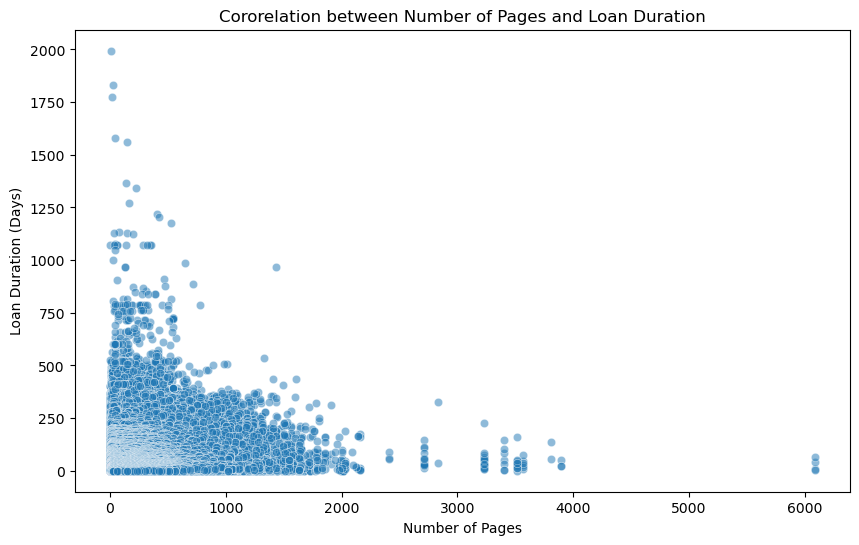

In [4]:
# Korrelation berechnen
correlation = df_clean['_pages_num'].corr(df_clean['Leihdauer'])
print(f"Korrelation zwischen Seitenzahl und Leihdauer: {correlation:.3f}")

# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='_pages_num', y='Leihdauer', alpha=0.5)
plt.title('Cororelation between Number of Pages and Loan Duration')
plt.xlabel('Number of Pages')
plt.ylabel('Loan Duration (Days)')
plt.show()

## Results of the analysis

After filtering for books (media types that include non-fiction, children's and young adult books, fiction, comics, foreign-language fiction, language courses or magazines), we have 1,343,816 entries.

The correlation between page count and loan duration is -0.002, indicating a very weak negative relationship. This means that books with more pages tend to be borrowed for slightly shorter periods, but the effect is minimal.

## Aggregated analysis per return group

Since people borrow several books at the same time and return them together, the loan period is often the same for all books in a return group. To avoid a distorted correlation, we aggregate the data per user, loan date, and return date:

- **Total number of pages per return group**: Sum of the pages of all books returned together.
- **Loan period**: The loan period for the group (same for all books).

We then calculate the correlation between these aggregated values.

Anzahl der aggregierten Rückgabe-Gruppen: 610731
       _pages_num  Leihdauer
count   610731.00  610731.00
mean       412.51      56.55
std        455.47      58.35
min          1.00       0.00
25%        143.00      18.00
50%        299.00      35.00
75%        511.00      75.00
max      26543.00    1994.00
Korrelation zwischen Gesamtseitenzahl pro Rückgabe-Gruppe und Leihdauer: -0.055


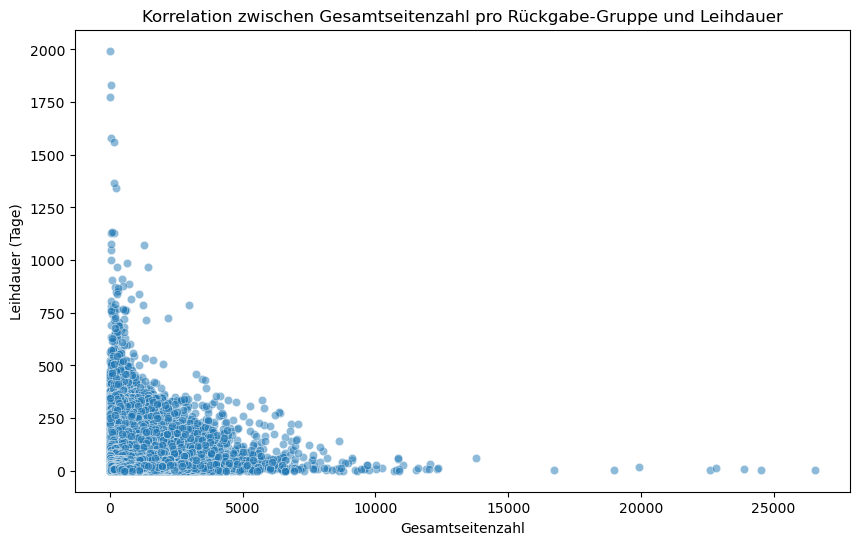

In [ ]:
# Daten aggregieren pro Benutzer, Ausleihdatum und Rückgabedatum
# Zuerst die Daten extrahieren (nur Datum)
df_clean['Ausleihdatum'] = pd.to_datetime(df_clean['Ausleihdatum/Uhrzeit']).dt.date
df_clean['Rückgabedatum'] = pd.to_datetime(df_clean['Rückgabedatum/Uhrzeit']).dt.date

# Gruppieren nach Benutzer-Systemnummer, Ausleihdatum und Rückgabedatum
grouped = df_clean.groupby(['Benutzer-Systemnummer', 'Ausleihdatum', 'Rückgabedatum']).agg({
    '_pages_num': 'sum',  # Gesamte Seitenzahl pro Rückgabe-Gruppe
    'Leihdauer': 'first'   # Leihdauer ist für alle Bücher in der Gruppe gleich
}).reset_index()

print(f"Number of aggregated return groups: {len(grouped)}")
print(grouped[['_pages_num', 'Leihdauer']].describe().round(2))

# Korrelation berechnen
correlation_agg = grouped['_pages_num'].corr(grouped['Leihdauer'])
print(f"Correlation between Total Number of Pages and Loan Duration per Return Group: {correlation_agg:.3f}")

# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped, x='_pages_num', y='Leihdauer', alpha=0.5)
plt.title('Correlation between Total Number of Pages and Loan Duration per Return Group')
plt.xlabel('Total Number of Pages')
plt.ylabel('Loan Duration (Days)')
plt.show()

## Results of the aggregated analysis

After aggregation per user, loan date, and return date, we have 610,731 return groups (compared to 1,343,816 individual book loans).

The correlation between the total number of pages per return group and the loan duration is -0.055, indicating a weak negative relationship. Return groups with more total pages tend to be kept slightly shorter, but the effect is minimal.

This result is even more robust because it considers actual return events. Nevertheless, the number of pages does not appear to be a strong predictor of loan duration.